In [ ]:
import os
import shutil
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


### Data Loader

In [ ]:
from torchvision import datasets, transforms
import torchvision

download_root = os.path.join(os.getcwd(), '/MNIST_DATASET/')

# MNIST Dataset
train_dataset = datasets.MNIST(root=download_root, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=download_root, train=False, transform=transforms.ToTensor(), download=False)

print(train_dataset.data.shape, train_dataset.targets.shape)
print(test_dataset.data.shape, test_dataset.targets.shape)

Extracting /MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to /MNIST_DATASET/MNIST/raw


Extracting /MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST_DATASET/MNIST/raw


Extracting /MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST_DATASET/MNIST/raw


Extracting /MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST_DATASET/MNIST/raw
Processing...
Done!
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:

nrm_cls = 0
x_nor_train, y_nor_train = train_dataset.data[train_dataset.targets == nrm_cls]/255.0, train_dataset.targets[train_dataset.targets == nrm_cls]
y_nor_train = torch.zeros_like(y_nor_train)

print(x_nor_train.shape, y_nor_train.shape)

x_test_nrm, y_test_nrm = test_dataset.data[test_dataset.targets == nrm_cls]/255.0, test_dataset.targets[test_dataset.targets == nrm_cls]
x_test_ano, y_test_ano = test_dataset.data[test_dataset.targets != nrm_cls][:x_test_nrm.shape[0]]/255.0, test_dataset.targets[test_dataset.targets != nrm_cls][:x_test_nrm.shape[0]]
x_test, y_test = torch.cat([x_test_nrm, x_test_ano], dim=0), torch.cat([y_test_nrm, y_test_ano], dim=0)
y_test = torch.where(y_test==nrm_cls, 0, 1)
print(x_test.shape, y_test.shape)
print(y_test[:10],y_test[-10:] )

torch.Size([5923, 28, 28]) torch.Size([5923])
torch.Size([1960, 28, 28]) torch.Size([1960])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
from torch.utils.data import DataLoader
from torch.utils import data
class MNIST_loader(data.Dataset):
    """This class is needed to processing batches for the dataloader."""
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __getitem__(self, index):
        """return transformed items."""
        x = self.data[index]
        y = self.target[index]
        return x.unsqueeze(0), y

    def __len__(self):
        """number of samples."""
        return len(self.data)



### Build Model

In [ ]:
class Reconstructor(nn.Module):
  def __init__(self, args):
    super(Reconstructor, self).__init__()
    self.std = args.std
    self.device = torch.device(args.cuda) 
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1), #14
                               nn.BatchNorm2d(64),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), #7
                               nn.BatchNorm2d(128),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), #7
                               nn.BatchNorm2d(256),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 0), #5
                               nn.BatchNorm2d(512),
                               nn.LeakyReLU(0.2, inplace=True))
    self.deconv1 = nn.Sequential(nn.ConvTranspose2d(512, 256, 3, 1, 0),
                                 nn.BatchNorm2d(256),
                                 nn.LeakyReLU(0.2, inplace=True))
    self.deconv2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 1, 1),
                                 nn.BatchNorm2d(128),
                                 nn.LeakyReLU(0.2, inplace=True))
    self.deconv3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, 2, 1),
                                 nn.BatchNorm2d(64),
                                 nn.LeakyReLU(0.2, inplace=True))
    self.deconv4 = nn.Sequential(nn.ConvTranspose2d(64, 1, 4, 2, 1),
                                 nn.Tanh())
    
  def forward(self, input):
    if self.training:
      noise = torch.normal(0.0, self.std * torch.ones_like(input)).to(self.device)
      x = self.conv1(torch.clamp(input + noise, 0.0, 1.0))
    else:
      x = self.conv1(input)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)
    return self.deconv4(x)

class Discriminator(nn.Module):
  def __init__(self, args):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1), #14
                               nn.BatchNorm2d(64))
    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), #7
                               nn.BatchNorm2d(128))
    self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 0), #5
                               nn.BatchNorm2d(256))
    self.conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 0), #3
                               nn.BatchNorm2d(512))
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(3*3*512, 1),
                            nn.Sigmoid())
    
  def forward(self, input):
    x = self.conv1(input)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    return self.fc(x)



In [ ]:
class ALOCC:
  def __init__(self, args, train_loader):
    self.args = args
    self.train_loader = train_loader
    self.device = torch.device(self.args.cuda)
    self.D, self.R = Discriminator(self.args).to(self.device), Reconstructor(self.args).to(self.device)

  def Reconstructor_loss(self, x, x_hat, Lambda):
    D_hat = self.D(x_hat)
    xent_loss = F.binary_cross_entropy(D_hat, torch.ones_like(D_hat))
    recon_err = torch.mean(torch.sum((x-x_hat)**2), dim=1)
    return xent_loss + Lambda * recon_err

  def Discriminator_loss(self, x, x_hat):
    D_x, D_x_hat = self.D(x), self.D(x_hat)
    xent_real = F.binary_cross_entropy(D_x, torch.ones_like(D_x))
    xent_fake = F.binary_cross_entropy(D_x_hat, torch.zeros_like(D_x_hat))
    return xent_real + xent_fake

  def train(self):
    self.D.train()
    self.R.train()
    optim_D = optim.Adam(self.D.parameters(), lr=self.args.lr_D, weight_decay=self.args.decay)
    optim_R = optim.Adam(self.R.parameters(), lr=self.args.lr_R, weight_decay=self.args.decay)
    lr_sched_D = optim.lr_scheduler.MultiStepLR(optim_D, self.args.milstones['D'], self.args.gamma['D'])
    lr_sched_R = optim.lr_scheduler.MultiStepLR(optim_R, self.args.milstones['R'], self.args.gamma['R'])
    
    for epoch in range(self.args.epochs):
      train_loss_D, train_loss_R = .0, .0
      for batch_idx, (data, targets) in enumerate(self.train_loader):
        X = data.to(self.device)

        optim_D.zero_grad()
        X_hat = self.R(X).detach()
        loss_D = self.Discriminator_loss(X, X_hat)
        loss_D.backward()
        train_loss_D += loss_D.item()
        optim_D.step()

        optim_R.zero_grad()
        X_hat = self.R(X)
        loss_R = self.Reconstructor_loss(X, X_hat, self.args.Lambda)
        loss_R.backward()
        train_loss_R += loss_R.item()
        optim_R.step()
        
        if batch_idx%10==0:
          print(batch_idx, " : D_loss =" , loss_D.item()/len(data), ", R_loss =" , loss_R.item()/len(data))
      
      lr_sched_D.step()
      lr_sched_R.step()
      train_loss = (train_loss_D + train_loss_R)/len(self.train_loader.dataset)
      print('Epoch {} Loss={:.3f}'.format(epoch, train_loss))
    return
    

### Train

In [ ]:
args = type('args', (), {})()
args.cuda = "cuda" if torch.cuda.is_available() else "cpu"
args.batch_size = 128
args.epochs = 50
args.lr_D = 0.0001
args.lr_R = 0.0001
args.std = 0.155
args.Lambda = 0.2
args.thres = 0.5
args.milstones = {'D':[25], 'R':[25]}
args.gamma = {'D':0.1, 'R':0.1}
args.decay = 0.9
                             
data_train = MNIST_loader(x_nor_train, y_nor_train)
dataloader_train = DataLoader(data_train, batch_size=args.batch_size, shuffle=True, num_workers=0)
    

data_test = MNIST_loader(x_test, y_test)
dataloader_test = DataLoader(data_test, batch_size=args.batch_size, shuffle=True, num_workers=0)

torch.Size([128, 1, 28, 28])


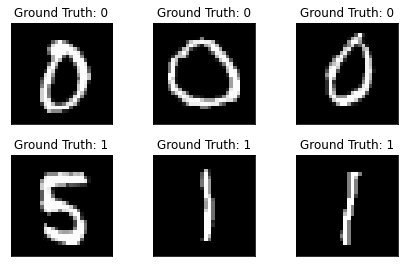

In [ ]:
examples = enumerate(dataloader_test)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#print(example_data[i][0])

In [ ]:
alocc = ALOCC(args, dataloader_train)
alocc.train()


0  : D_loss = 0.010834064334630966 , R_loss = 118.47858428955078
10  : D_loss = 0.0016032186103984714 , R_loss = 40.74507522583008
20  : D_loss = 0.00039026845479384065 , R_loss = 21.960460662841797
30  : D_loss = 0.00022184636327438056 , R_loss = 15.805841445922852
40  : D_loss = 0.0003050036611966789 , R_loss = 12.977266311645508
Epoch 0 Loss=31.077
0  : D_loss = 0.000590602052398026 , R_loss = 11.104331016540527
10  : D_loss = 0.0002470484469085932 , R_loss = 9.361700057983398
20  : D_loss = 0.00028324039885774255 , R_loss = 8.235943794250488
30  : D_loss = 0.0001816626900108531 , R_loss = 7.327758312225342
40  : D_loss = 0.00016716093523427844 , R_loss = 6.885141372680664
Epoch 1 Loss=8.345
0  : D_loss = 0.00026033492758870125 , R_loss = 6.4833784103393555
10  : D_loss = 0.0001260754361283034 , R_loss = 5.684416770935059
20  : D_loss = 0.00014008092693984509 , R_loss = 5.034746170043945
30  : D_loss = 0.00010893083526752889 , R_loss = 4.622430324554443
40  : D_loss = 0.000115766495

### Test

In [ ]:
from sklearn import metrics
def evaluate(alocc, test_loader, thres):
  alocc.D.eval()
  alocc.R.eval()
  real, pred = [], []
  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
      X = data.to(alocc.device)
      X_hat = alocc.R(X).cpu().numpy()
      if batch_idx==0:
        '''
        for i in range(50):
          fig = plt.figure()
          plt.subplot(1,2,1)
          plt.tight_layout()
          plt.imshow(X[i][0].cpu(), cmap='gray', interpolation='none')
          plt.xticks([])
          plt.yticks([])

          plt.subplot(1,2,2)
          plt.tight_layout()
          plt.imshow(X_hat[i][0], cmap='gray', interpolation='none')
          plt.xticks([])
          plt.yticks([])
          plt.show()
       '''
      pred_tmp = [0 if x<thres else 1 for x in alocc.D(alocc.R(X)).cpu().numpy().reshape(-1)]
      real.append(targets.cpu().numpy())
      pred.append(pred_tmp)
    real = np.concatenate(real)
    pred = np.concatenate(pred)
    acc = metrics.accuracy_score(real, pred)
    precision, recall, f, _ = metrics.precision_recall_fscore_support(real, pred, zero_division=0)
    print(acc, precision, recall, f)



In [ ]:
for thres in np.arange(0.1, 0.9, 0.1):
  evaluate(alocc, dataloader_test, thres)

0.5 [0.  0.5] [0. 1.] [0.         0.66666667]
0.5005102040816326 [1.         0.50025523] [0.00102041 1.        ] [0.00203874 0.6668935 ]
0.5102040816326531 [0.64705882 0.50528541] [0.04489796 0.9755102 ] [0.08396947 0.66573816]
0.5561224489795918 [0.61506276 0.53711201] [0.3       0.8122449] [0.40329218 0.64662876]
0.6040816326530613 [0.58673469 0.63010204] [0.70408163 0.50408163] [0.64007421 0.5600907 ]
0.6056122448979592 [0.56208758 0.85324232] [0.95612245 0.25510204] [0.70797129 0.39277298]
0.5448979591836735 [0.52357985 0.96808511] [0.99693878 0.09285714] [0.68657765 0.16945996]
0.5051020408163265 [0.5025641 1.       ] [1.         0.01020408] [0.66894198 0.02020202]


### Visualize

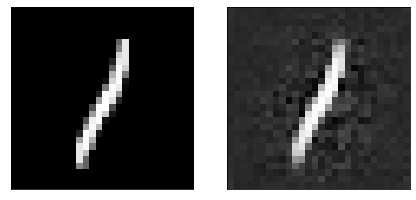

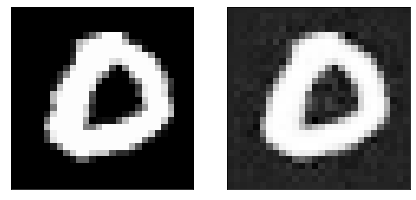

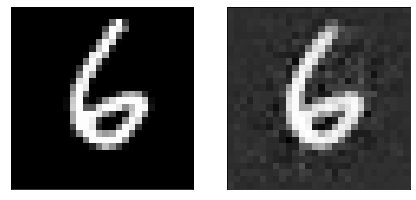

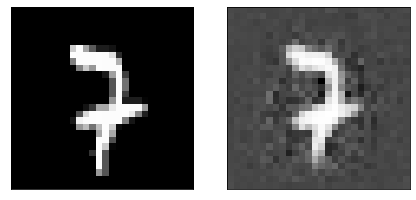

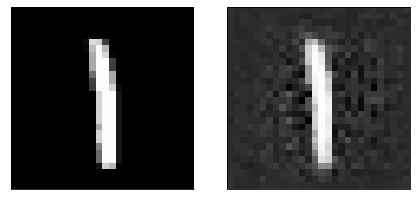

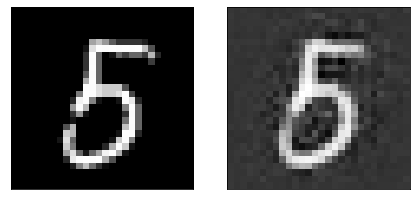

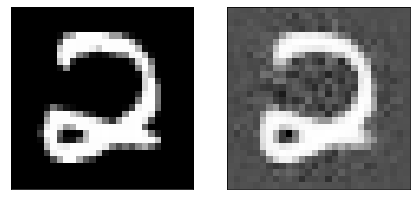

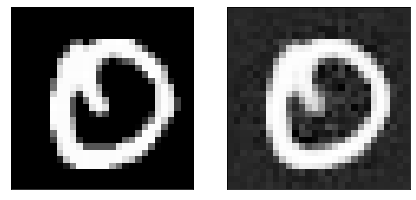

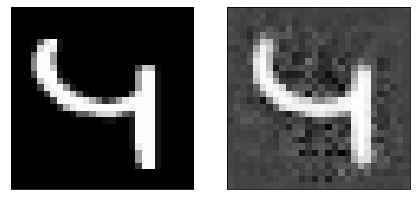

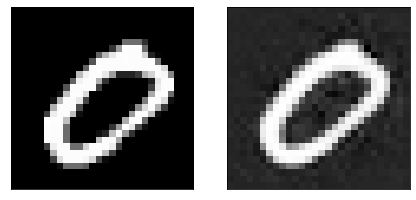

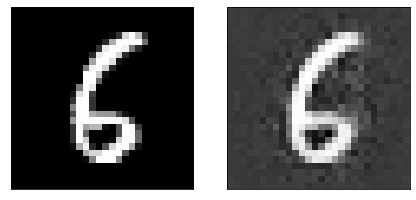

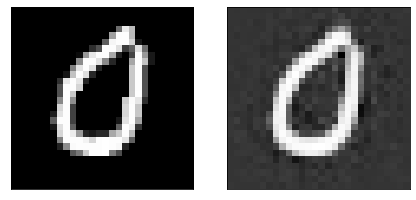

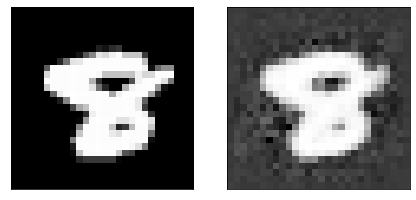

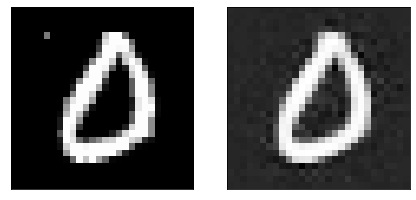

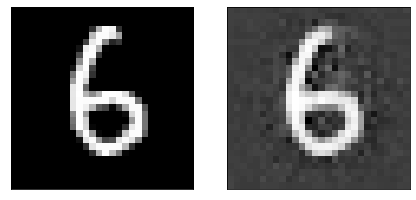

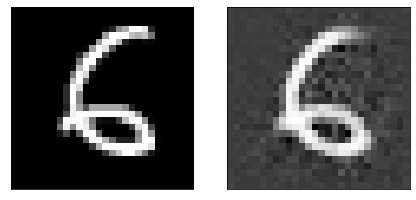

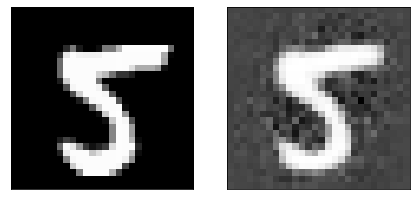

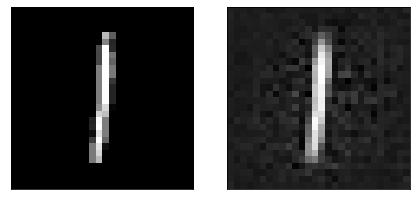

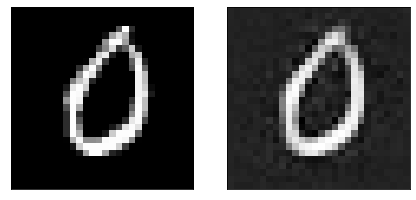

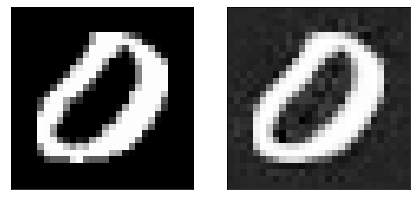

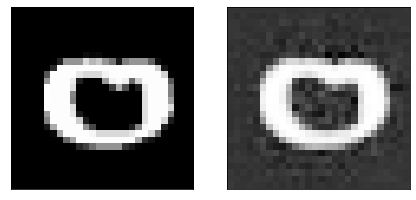

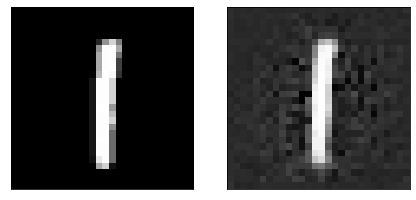

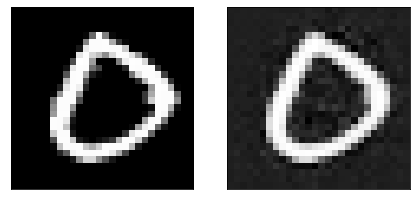

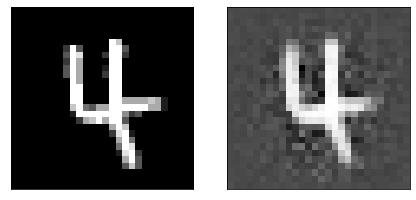

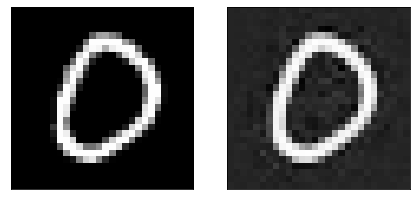

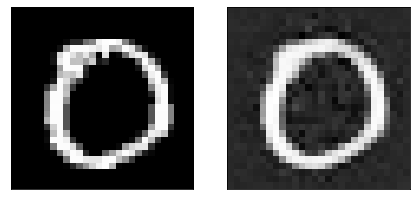

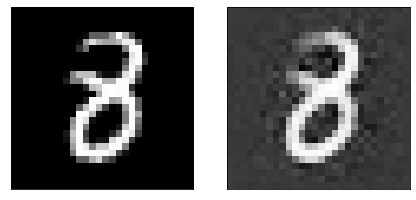

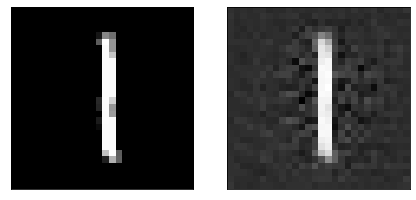

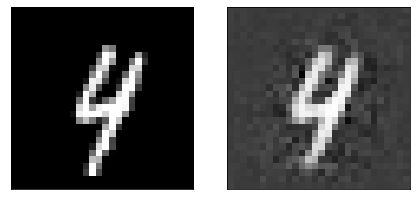

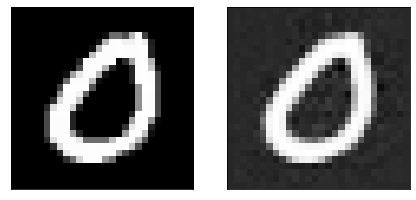

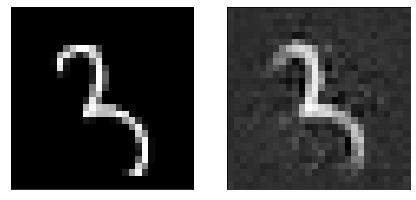

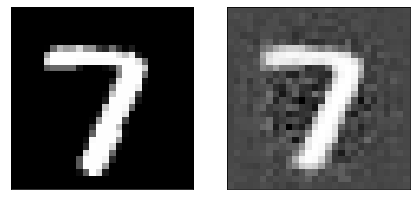

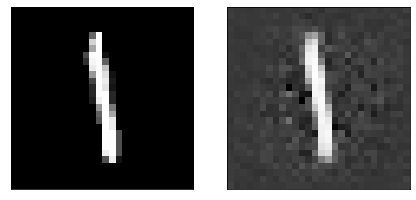

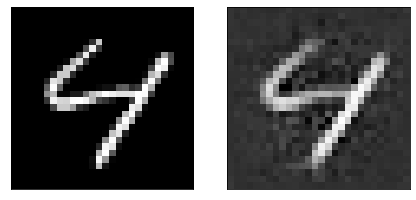

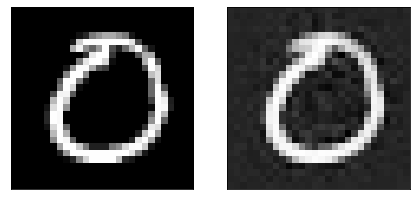

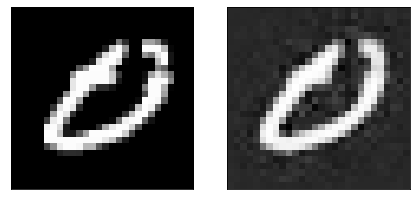

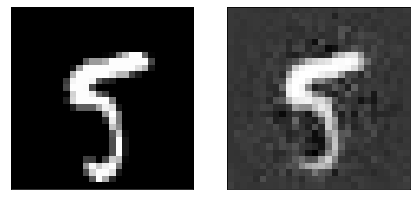

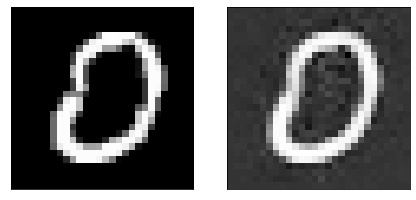

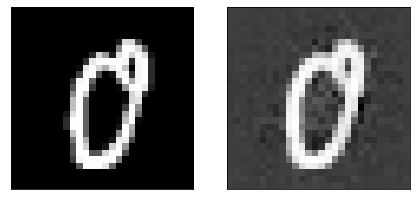

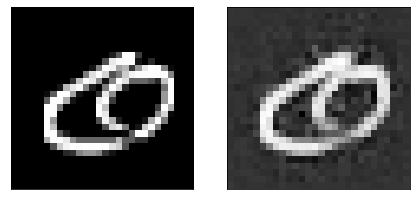

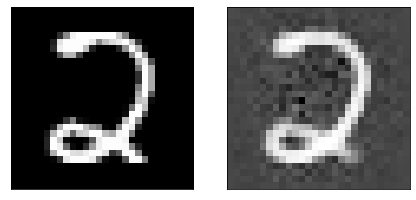

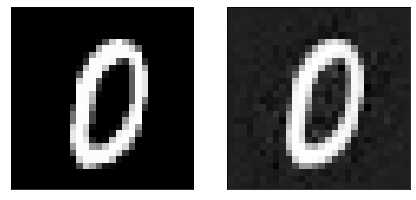

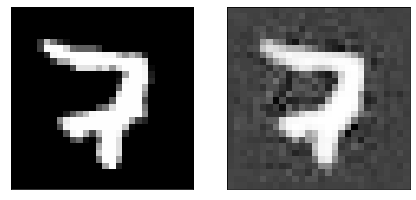

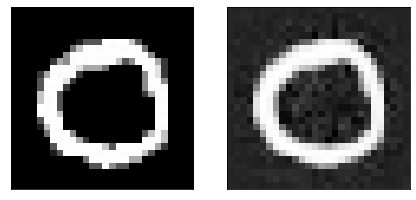

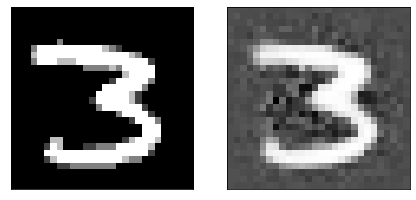

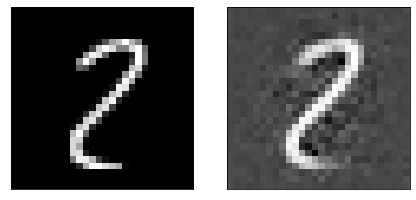

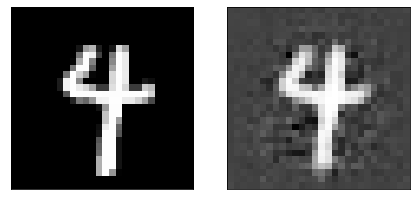

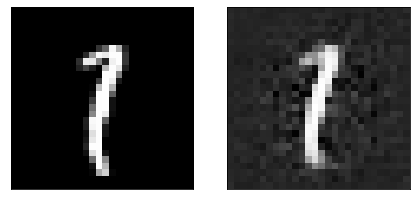

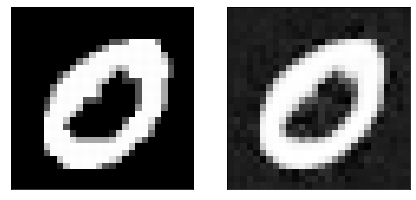

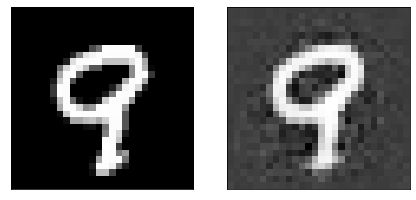

In [ ]:
  alocc.D.eval()
  alocc.R.eval()
  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(dataloader_test):
      X = data.to(alocc.device)
      X_hat = alocc.R(X).cpu().numpy()
      if batch_idx==0:
        for i in range(50):
          fig = plt.figure()
          plt.subplot(1,2,1)
          plt.tight_layout()
          plt.imshow(X[i][0].cpu(), cmap='gray', interpolation='none')
          plt.xticks([])
          plt.yticks([])

          plt.subplot(1,2,2)
          plt.tight_layout()
          plt.imshow(X_hat[i][0], cmap='gray', interpolation='none')
          plt.xticks([])
          plt.yticks([])
          plt.show()